<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Update-the-simulate-mine-function" data-toc-modified-id="Update-the-simulate-mine-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Update the simulate mine function</a></span></li><li><span><a href="#Main-function" data-toc-modified-id="Main-function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main function</a></span></li><li><span><a href="#Check-on-intermediate-results" data-toc-modified-id="Check-on-intermediate-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check on intermediate results</a></span></li><li><span><a href="#Calculate-mining-production-benchmark" data-toc-modified-id="Calculate-mining-production-benchmark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate mining production benchmark</a></span></li></ul></div>

# Update the simulate mine function 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
import random 
from scipy import stats

from mine_simulation_tools import *
from refinery import *
from scrap_supply_tools import *
from demand_tools import *
from price_formation import *

In [2]:
# High level parameters
price_scenarios=pd.read_excel('Data/primary supply/Price scenarios.xlsx',sheet_name='Sheet1', index_col=0)
historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0)
historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0)

# Specific prod and mine data
historical_mining_prod=historical_prod.loc[:, 'Total mining production']
historical_lme_price=historical_price.loc[:, 'LME']
historical_tcrc=historical_price.loc[:, 'Annual TCRC']
historical_no2=historical_price.loc[:, 'No.2 ref']
historical_sp2=historical_lme_price-historical_no2

In [3]:
# Primary supply data and patameters
operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool.xls', sheet_name='Sheet1', index_col=0)
incentive_pool=pd.read_excel('Data/primary supply/Incentive mine pool.xls', sheet_name='Sheet1', index_col=0)
open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='Sheet1', index_col=0)
# open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter new benchmark.xlsx', sheet_name='Sheet1', index_col=0)
pri_hyper_param=pd.read_excel('Data/primary supply/Hyperparameters.xlsx', sheet_name='Sheet1', index_col=0)

In [4]:
# Refinery parameters
ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
conc_to_cathode_eff=0.99
scrap_to_cathode_eff=0.99
sec_coef=0

In [5]:
# Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

In [6]:
# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))

In [7]:
# Scrap supply parameters
use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0)
product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)

# Sector end use to product matrix 
use_product_history=pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
                                 index=use_sector_combined.index, columns=sector_to_product.index)
# Product to waste matrices
product_to_waste_collectable=product_to_waste.iloc[:, :-2]
product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

# Product lifetime parameters and frequencies
product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
product_lifetime_df=lifetime_df(product_lifetime)
product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)

# Recycling and fabrication efficiencies
sort_eff=recycle_efficiency.iloc[:, 0]
collect_rate=recycle_efficiency.iloc[:, 1]
fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
new_scrap_gen=1/fab_eff-1

# New scrap ratios
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

In [8]:
# Price formation parameters
price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)

cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']

# Main function

In [9]:
# Initialize cathode price
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
price_base=price_scenarios.loc[:, 'Scenario 1: constant']
price_high=price_scenarios.loc[:, 'Scenario 2: permanent high']
price_low=price_scenarios.loc[:, 'Scenario 3: permanent low']
price_up=price_scenarios.loc[:, 'Scenario 4: growing']
price_down=price_scenarios.loc[:, 'Scenario 5: shrinking']
price_series=price_base.copy()

# Initialize TCRC
tcrc_series=pd.Series(0, index=price_base.index)
tcrc_series.loc[:'20180101']=historical_tcrc.loc[1991:2018].values

# Initialize SP2
sp2_series=pd.Series(0, index=price_base.index)
sp2_series.loc[:'20180101']=historical_sp2.loc[1991:2018].values

In [10]:
# Initialize mining stats
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
total_mining_prod=pd.Series(0, index=simulation_time)

# Initilize sxew ids
sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
sxew_new=pd.Series(0, index=simulation_time)
sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']

# Initialize refinery stats
ref_stats=ref_stats_init(simulation_time, ref_hyper_param)

# Initialize concentrate prod, add 2017
conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']

# Initialize refined supply and demand
ref_prod_series=pd.Series(0, index=simulation_time)
ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])

# Initialize old scrap history
product_eol_history=product_reach_eol(use_product_history, product_lifetime_freq_df)
waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
                                     index=product_eol_history.index, 
                                     columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)

waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

# Initialize old scrap history
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
for year_i in waste_from_new_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    waste_from_new_year_i=\
    simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i.values

waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])

waste_all_life=waste_from_old_all_life+waste_from_new_all_life

# Initialize scrap demand
direct_melt_scrap_demand=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})


In [11]:
# Tuning parameters
sec_coef=0
open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='Sheet1', index_col=0)
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']


In [12]:
for year_i in np.arange(2018, 2041):
    
    print(year_i)
    t=datetime(year_i, 1, 1)
    t_lag_1=datetime(year_i-1, 1, 1)
    t_lag_2=datetime(year_i-2, 1, 1)
    
    #### Price formation ####
    if year_i > 2018:        
        ########### Define Cathode price here #######
        cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
        price_series.loc[t]=cathode_price_predict(price_series.loc[t_lag_1], cathode_bal_l1, cathode_sd_elas)

        ########### Define TCRC here ###########
        conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
        tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], conc_bal_l1, conc_sd_elas)
        
        ########### Define SP2 here #######
        scrap_balance=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
        cathode_price_diff=price_series.loc[t]-price_series.loc[t_lag_1]
        sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], scrap_balance, 
                                      scrap_sd_elas=sp2_sd_elas, cathode_diff=cathode_price_diff, 
                                      cathode_sp2_elas=cathode_sp2_elas)
        
        ########### Define SP1 here #######
        
        ########### Define alloyed here #######
        
        
    # TCRC to cents per pound
    tcrc_cpp_series = tcrc_series.copy().div(22.0462)

 
    #### Production of operating mine ####
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                         mine_life_stats_panel_operating, mine_data, 
                                                         price_series, tcrc_cpp_series, pri_hyper_param)
        mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

    # Total production statistics
    prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
    sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
    conc_operating=prod_operating-sxew_operating
    print('Production from 2018 operating mines: ', prod_operating.loc[t])
    
    
    #### Production of new mines ####
    if year_i > 2018:
        # Read subsample size parameter and generate new incentive pool for year_i
        subsample_size=open_parameter.loc[year_i, 'Subsample size']
        mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, price_series, 
                                           pri_hyper_param, subsample_size, irr_cutoff=0.15)
        print('New mines opening this year: ', mine_pool_new_year_i.shape[0])
      
        # Initialize mine life panel data for incentive pool year_i
        mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)
      
        # Append new incentive pool at year_i
        mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
        mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)
        
        for mine_id in mine_pool_new.index:
            mine_data = mine_pool_new.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                             mine_life_stats_panel_new, mine_data, 
                                                             price_series, tcrc_cpp_series, pri_hyper_param)
            mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values
        
        
        # Total production statistics
        prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
        conc_new=prod_new-sxew_new
        print('Production from new mines: ', prod_new.loc[t])
        
        # Update incentive pool info
        mine_pool_new_last=mine_pool_new.copy()
        mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()

        
    #### Update total mining production ####
    if year_i == 2018:
        conc_new=pd.Series(0, index=simulation_time)

    conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
    sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
    
    
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, price_series, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values
    
    # Demand by shape and refined copper demand
    demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
    demand_by_shape=pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
                                 index=demand_by_sector.index, columns=sector_shape_matrix.index)
    ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
    
    
    #### Production of refineries ####
    if year_i == 2018:
        pass
    else:
        ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                            ref_demand_series, waste_all_life.sum(axis=1),
                                                            sec_coef, ref_stats, ref_hyper_param, 
                                                            growth_lag=1)
        ref_stats.loc[t, :]=ref_stats_next
    
    total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
    ref_prod_series.loc[t]=total_ref_prod
    print('Total refinery production: ', total_ref_prod)

    
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                          .loc[:, list(sector_to_product.columns)].loc[year_i, :]
        use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_all_life.loc[year_i]=use_product_year_i.values
        
        # Product reaching end of life and waste collected
        product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
        waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_from_old_future.loc[year_i]=waste_collected_year_i

        
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future.loc[year_i]=waste_from_new_year_i
    
        # All scrap
        waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i
    
    
    #### Demand of scrap
    direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
    refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
    total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
    total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i
    

2018
Production from 2018 operating mines:  20551.422173426887
Total refinery production:  23832.000000090466
2019
Production from 2018 operating mines:  18306.673585463734
New mines opening this year:  159
Production from new mines:  2093.7150744906858
Total refinery production:  24961.92372620356
2020
Production from 2018 operating mines:  17416.00404082973
New mines opening this year:  0
Production from new mines:  4373.729853633356
Total refinery production:  24997.601163028045
2021
Production from 2018 operating mines:  16610.57644046758
New mines opening this year:  76
Production from new mines:  5184.911450609958
Total refinery production:  25885.73781477088
2022
Production from 2018 operating mines:  15839.285515875492
New mines opening this year:  0
Production from new mines:  6294.646898699635
Total refinery production:  26207.179600337888
2023
Production from 2018 operating mines:  14821.046856486664
New mines opening this year:  109
Production from new mines:  6970.94820483

# Check on intermediate results

<IPython.core.display.Javascript object>


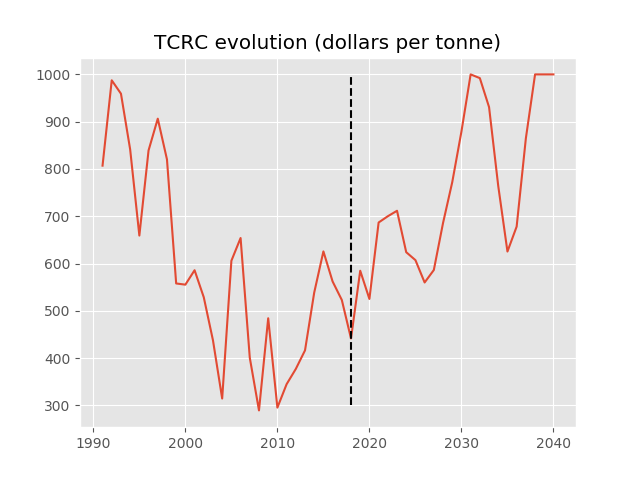

In [14]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(tcrc_series)
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [300, 1000], 'k--')
plt.title('TCRC evolution (dollars per tonne)')
plt.show()


<IPython.core.display.Javascript object>


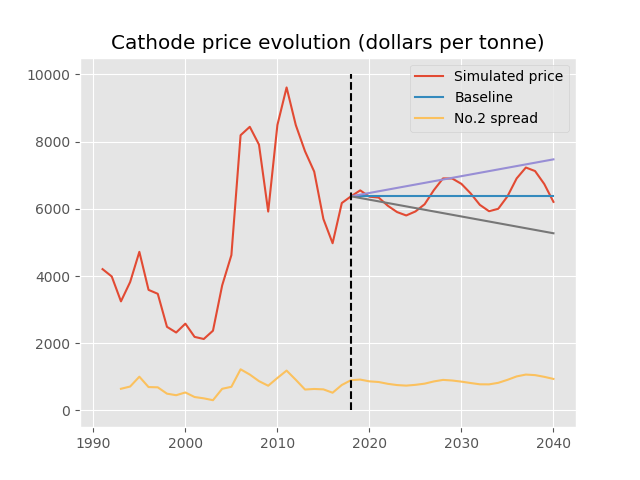

In [51]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(price_series, label='Simulated price')
plt.plot(price_base.iloc[27:], label='Baseline')
plt.plot(price_up.iloc[27:], label='')
plt.plot(price_down.iloc[27:], label='')
plt.plot(sp2_series, label='No.2 spread')
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [0, 10000], 'k--')

plt.legend()
plt.title('Cathode price evolution (dollars per tonne)')
plt.show()


In [16]:
price_series.loc['19930101':'20180101'].corr(sp2_series.loc['19930101':'20180101'])

0.8088807713974744

In [17]:
price_series.loc['20190101':].corr(sp2_series.loc['20190101':])

0.8700831971900731

In [18]:
conc_prod_history=pd.Series(historical_prod.loc[:, 'Concentrate production'].values, 
                            index=pd.date_range('19500101', '20180101', freq='AS'))
conc_demand_history=pd.Series(historical_prod.loc[:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)

mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']

mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')

mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

<IPython.core.display.Javascript object>


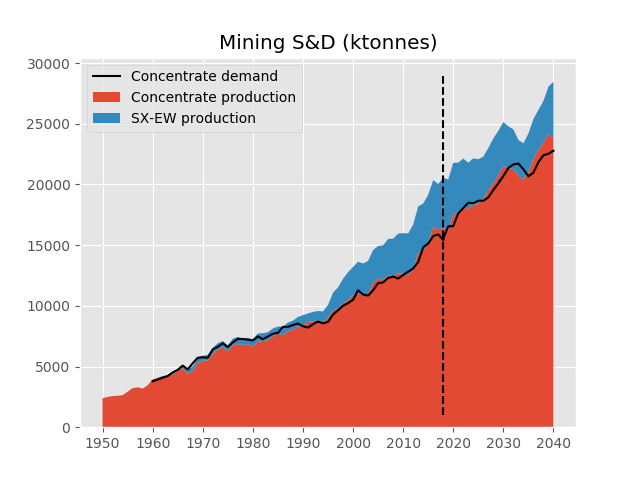

In [19]:
%matplotlib notebook
#plt.plot(conc_prod_history, 'b', label='Supply')
#plt.plot(conc_prod_series, 'b')
plt.plot(conc_demand_history, 'k', label='Concentrate demand')
plt.plot(ref_stats.loc[:, 'Primary production'].rename('').div(0.99), 'k')
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 29000], 'k--')
plt.stackplot(mining_prod_df_all.index, mining_prod_df_all.transpose(), labels=mining_prod_df_all.columns)
plt.legend(loc=2)
plt.title('Mining S&D (ktonnes)')

plt.show()

In [20]:
ref_prod_history=pd.Series(historical_prod.loc[:, 'Primary refining production'].values
                           +historical_prod.loc[:, 'Secondary refining production'].values
                           +historical_prod.loc[:, 'SX-EW production'].values, 
                           index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_history=pd.Series(historical_prod.loc[:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))

ref_breakdown_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[:-1, :]
ref_breakdown_history.index=pd.date_range('19500101', '20170101', freq='AS')

ref_breakdown_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_breakdown_future.columns=ref_breakdown_history.columns

ref_breakdown_all=pd.concat([ref_breakdown_history, ref_breakdown_future])

<IPython.core.display.Javascript object>


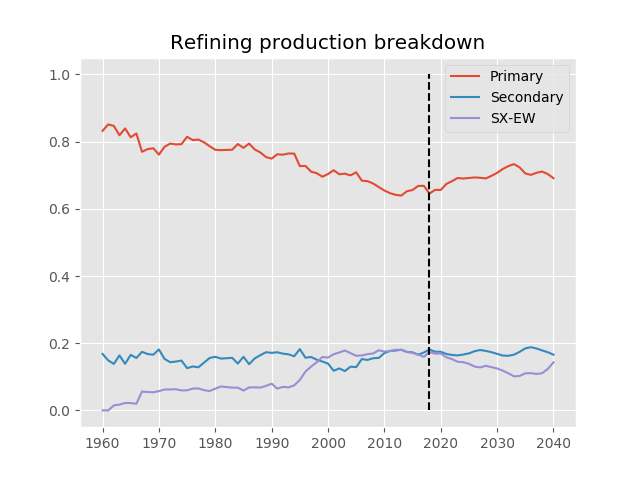

In [21]:
%matplotlib notebook
plt.plot(ref_breakdown_all.iloc[:, 0].div(ref_breakdown_all.sum(axis=1)), label='Primary')
plt.plot(ref_breakdown_all.iloc[:, 1].div(ref_breakdown_all.sum(axis=1)), label='Secondary')
plt.plot(ref_breakdown_all.iloc[:, 2].div(ref_breakdown_all.sum(axis=1)), label='SX-EW')
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [0, 1], 'k--')

plt.legend()
plt.title('Refining production breakdown')
plt.show()

<IPython.core.display.Javascript object>


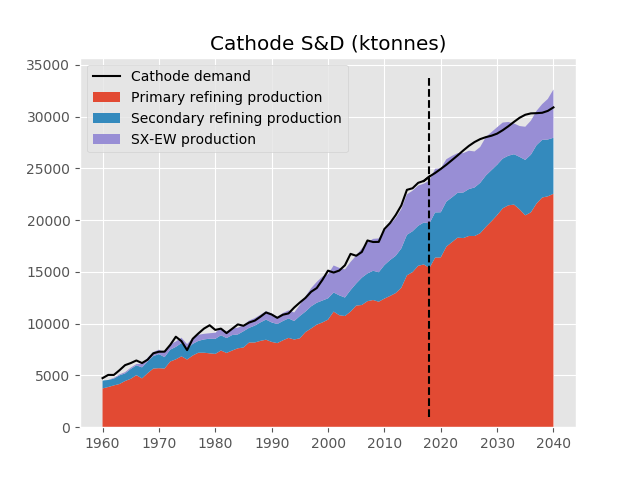

In [22]:
%matplotlib notebook
# plt.plot(ref_prod_history, 'b')
# plt.plot(ref_prod_series, 'b')
plt.plot(ref_demand_history, 'k', label='Cathode demand')
plt.plot(ref_demand_series, 'k')
plt.stackplot(ref_breakdown_all.index, ref_breakdown_all.transpose(), labels=ref_breakdown_all.columns)
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 34000], 'k--')

plt.legend(loc=2)
plt.title('Cathode S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


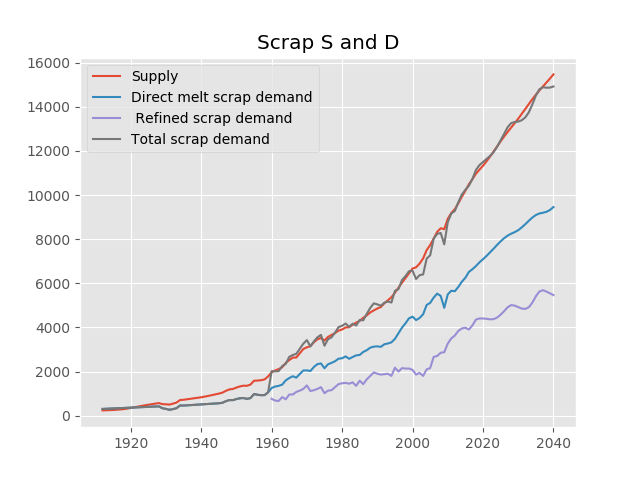

In [23]:
%matplotlib notebook
plt.plot(waste_all_life.sum(axis=1), label='Supply')
plt.plot(total_scrap_demand_all_life.loc[:, 'Direct melt scrap'], label='Direct melt scrap demand')
plt.plot(total_scrap_demand_all_life.loc[:, 'Refined scrap'], label=' Refined scrap demand')
plt.plot(total_scrap_demand_all_life.sum(axis=1), label='Total scrap demand')

plt.title('Scrap S and D')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


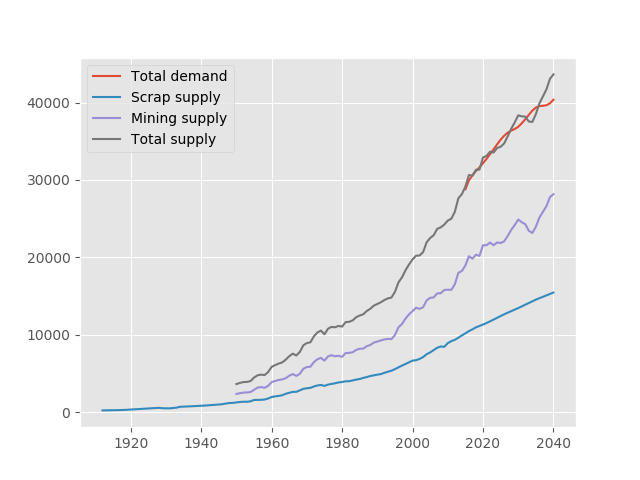

In [24]:
%matplotlib notebook
plt.plot(demand_prediction.sum(axis=1), label='Total demand')
plt.plot(waste_all_life.sum(axis=1), label='Scrap supply')
plt.plot(pd.Series(mining_prod_df_all.sum(axis=1).values, index=np.arange(1950, 2041)).mul(0.99), label='Mining supply')
plt.plot(waste_all_life.sum(axis=1)+pd.Series(mining_prod_df_all.sum(axis=1).values, index=np.arange(1950, 2041)).mul(0.99), 
         label='Total supply')

plt.legend()
plt.show()

This one shows the essence of the problem:
1. Demand not growing so fast, based on current GDP projections
2. On a high level, demand=scrap supply+mining supply. If projection for scrap supply is growing fast, mining supply have to grow slow
3. So need to tune scrap supply to make it grow not too fast

In [67]:
sp2_first_diff=pd.Series(sp2_series.diff().values, index=np.arange(1991,2041))
cathode_effect=pd.Series(price_series.diff().mul(cathode_sp2_elas).values, index=np.arange(1991,2041))
sd_effect=(waste_all_life.sum(axis=1)-total_scrap_demand_all_life.sum(axis=1))\
         .mul(sp2_sd_elas).shift(1)
resid=sp2_first_diff-sd_effect.loc[1992:]

In [46]:
cathode_effect.loc[:2018].abs().mean()

164.3562787172044

In [47]:
sd_effect.loc[1992:2018].abs().mean()

16.43562795568631

In [60]:
(sp2_first_diff-sd_effect.loc[1992:]).corr(sd_effect.loc[1992:2018])

0.42685531778423863

<IPython.core.display.Javascript object>


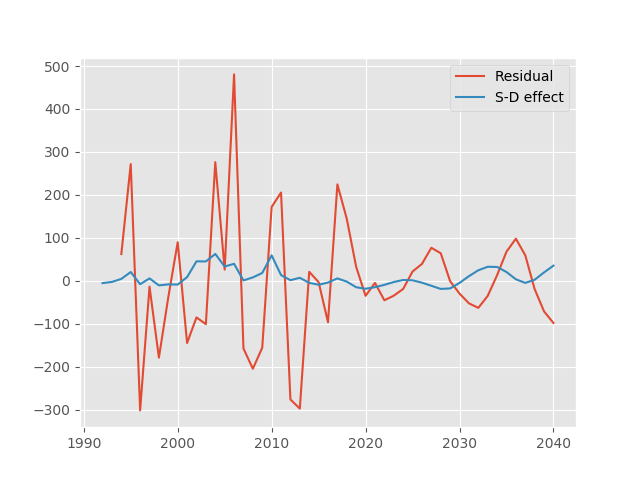

In [58]:
%matplotlib notebook
# plt.plot(sp2_first_diff, label='SP2 first diff')
# plt.plot(cathode_effect, label='cathode effect')
plt.plot(sp2_first_diff-sd_effect.loc[1992:], label='Residual')
plt.plot(sd_effect.loc[1992:], label='S-D effect')

plt.legend()
plt.show()

# Calculate mining production benchmark

In [30]:
# Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

In [28]:
# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))

In [29]:
for year_i in np.arange(2018, 2041):
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, price_base, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values

In [32]:
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

In [34]:
for year_i in np.arange(2018, 2041):
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                          .loc[:, list(sector_to_product.columns)].loc[year_i, :]
        use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_all_life.loc[year_i]=use_product_year_i.values
        
        # Product reaching end of life and waste collected
        product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
        waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_from_old_future.loc[year_i]=waste_collected_year_i

        
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future.loc[year_i]=waste_from_new_year_i
    
        # All scrap
        waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i

<IPython.core.display.Javascript object>


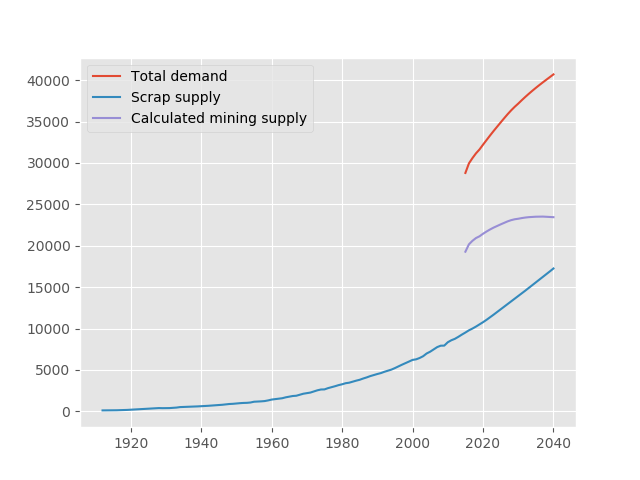

In [33]:
%matplotlib notebook
plt.plot(demand_prediction.sum(axis=1), label='Total demand')
plt.plot(waste_all_life.sum(axis=1), label='Scrap supply')
plt.plot(demand_prediction.sum(axis=1)-waste_all_life.sum(axis=1), label='Calculated mining supply')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


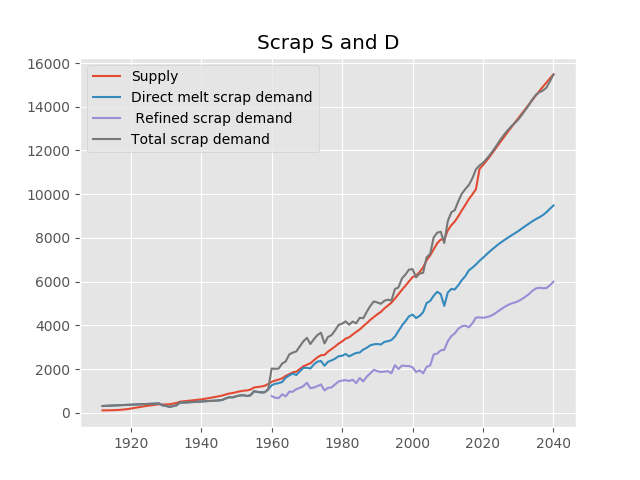

In [35]:
%matplotlib notebook
plt.plot(waste_all_life.sum(axis=1), label='Supply')
plt.plot(total_scrap_demand_all_life.loc[:, 'Direct melt scrap'], label='Direct melt scrap demand')
plt.plot(total_scrap_demand_all_life.loc[:, 'Refined scrap'], label=' Refined scrap demand')
plt.plot(total_scrap_demand_all_life.sum(axis=1), label='Total scrap demand')

plt.title('Scrap S and D')
plt.legend()
plt.show()